# Enumerating an MGRS Tile

The previous notebook went into detail about specifying the inputs for a single DIST-S1 product. Now, we want to create a time-series of DIST-S1 products, and specifying these inputs.

To do this, we will still select an Area of Interest (AOI). This time, we will not need to specify the track number nor the post-image date. We will simply get *all* the products that can be obtained from a given MGRS tile. Additional temporal ranges on the post-image dates or track numbers can be used to filter the number of products, but that is not the focus of this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from pathlib import Path

import asf_search as asf
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.crs import CRS
from shapely.geometry import Point

from dist_s1_enumerator import (
    get_burst_table_from_mgrs_tiles,
    get_lut_by_mgrs_tile_ids,
    get_mgrs_burst_lut_path,
    get_mgrs_tiles_overlapping_geometry,
)
from dist_s1_enumerator.asf import get_rtc_s1_ts_metadata_from_mgrs_tiles
from dist_s1_enumerator.dist_enum import enumerate_dist_s1_products

asf.constants.INTERNAL.CMR_TIMEOUT = 300

/Users/cmarshak/miniforge3/envs/dist-s1-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Provide AOI

In [3]:
# Wax Lake Delta
point = Point(-91.45, 29.5)
df_aoi = gpd.GeoDataFrame(geometry=[point], crs=CRS.from_epsg(4326))

# Visualize MGRS Tiles overlapping the AOI

This is a rehash of the previous notebook as it is still relevant./

In [4]:
df_mgrs_tiles = get_mgrs_tiles_overlapping_geometry(point)
df_mgrs_tiles.head()

,mgrs_tile_id,utm_epsg,utm_wkt,geometry
0,15RXN,32615,"MULTIPOLYGON(((600000 3300000,600000 3190200,7...","POLYGON ((-91.96499 29.82641, -91.97495 28.835..."


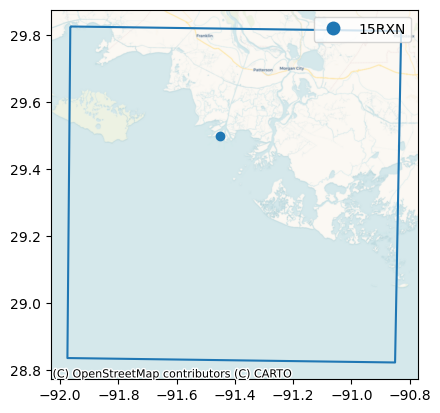

In [5]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.geometry = df_mgrs_tiles_plot.geometry.boundary
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, legend=True, ax=ax
)
df_aoi.plot(ax=ax)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

# Visualize Bursts over the MGRS Tiles

In [6]:
MGRS_TILE_IDS = ["15RXN"]

In [7]:
df_bursts = get_burst_table_from_mgrs_tiles(MGRS_TILE_IDS)
df_bursts.head()

,jpl_burst_id,track_number,acq_group_id_within_mgrs_tile,mgrs_tile_id,geometry
0,T063-133337-IW3,63,0,15RXN,"POLYGON ((-91.1627 28.57844, -90.35433 28.6981..."
1,T063-133338-IW2,63,0,15RXN,"POLYGON ((-92.07298 28.55011, -91.15958 28.692..."
2,T063-133338-IW3,63,0,15RXN,"POLYGON ((-91.19651 28.74463, -90.38697 28.864..."
3,T063-133339-IW2,63,0,15RXN,"POLYGON ((-92.10828 28.71639, -91.19336 28.858..."
4,T063-133339-IW3,63,0,15RXN,"POLYGON ((-91.23035 28.91082, -90.41946 29.030..."


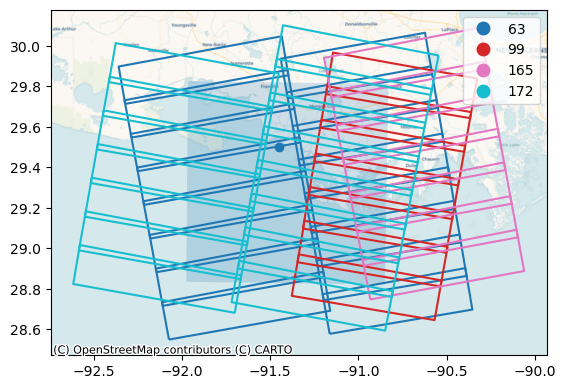

In [8]:
fig, ax = plt.subplots()
df_mgrs_tiles_plot = df_mgrs_tiles.copy()
df_mgrs_tiles_plot.plot(
    column="mgrs_tile_id", categorical=True, ax=ax, alpha=0.2
)
df_aoi.plot(ax=ax)
df_bursts_plot = df_bursts.copy()
df_bursts_plot.geometry = df_bursts_plot.geometry.boundary
df_bursts_plot.plot(column="track_number", categorical=True, ax=ax, legend=True)
ctx.add_basemap(
    ax, crs=df_mgrs_tiles.crs.to_string(), source=ctx.providers.CartoDB.Voyager
)

# Get the RTC Metadata for the Time-Series over the MGRS Tiles

Rather than selecting a track, we can enumerate across all tracks. Note that I commented out the track numbers, which would be used to group a pass.

In [9]:
df_ts = get_rtc_s1_ts_metadata_from_mgrs_tiles(
    MGRS_TILE_IDS,
    # track_numbers=[63]
)
df_ts.head(5)

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token
0,OPERA_L2_RTC-S1_T063-133337-IW3_20220101T00102...,T063-133337-IW3,2022-01-01 00:10:21+00:00,2022-01-01,VV+VH,63,487,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16935 28.57693, -90.33732 28.705...",15RXN,0,63
1,OPERA_L2_RTC-S1_T063-133337-IW3_20220113T00102...,T063-133337-IW3,2022-01-13 00:10:20+00:00,2022-01-13,VV+VH,63,489,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17054 28.57716, -90.33852 28.705...",15RXN,0,63
2,OPERA_L2_RTC-S1_T063-133337-IW3_20220125T00102...,T063-133337-IW3,2022-01-25 00:10:20+00:00,2022-01-25,VV+VH,63,491,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17052 28.57731, -90.3385 28.7054...",15RXN,0,63
3,OPERA_L2_RTC-S1_T063-133337-IW3_20220206T00101...,T063-133337-IW3,2022-02-06 00:10:19+00:00,2022-02-06,VV+VH,63,493,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17071 28.57759, -90.33869 28.705...",15RXN,0,63
4,OPERA_L2_RTC-S1_T063-133337-IW3_20220218T00101...,T063-133337-IW3,2022-02-18 00:10:19+00:00,2022-02-18,VV+VH,63,495,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17005 28.57644, -90.32587 28.706...",15RXN,0,63


# Enumerate DIST-S1 Products

In [10]:
df_products = enumerate_dist_s1_products(df_ts, MGRS_TILE_IDS)
df_products.head()

Enumerate by MGRS tiles: 100%|█| 1/1 [00:00<0


,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
0,OPERA_L2_RTC-S1_T063-133337-IW3_20250602T00102...,T063-133337-IW3,2025-06-02 00:10:23+00:00,2025-06-02,VV+VH,63,695,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16812 28.57689, -90.3531 28.7024...",15RXN,0,63,pre,0
1,OPERA_L2_RTC-S1_T063-133337-IW3_20250602T00102...,T063-133337-IW3,2025-06-02 00:10:23+00:00,2025-06-02,VV+VH,63,695,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16812 28.57689, -90.3531 28.7024...",15RXN,0,63,pre,0
2,OPERA_L2_RTC-S1_T063-133337-IW3_20250602T00102...,T063-133337-IW3,2025-06-02 00:10:23+00:00,2025-06-02,VV+VH,63,695,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.16812 28.57689, -90.3531 28.7024...",15RXN,0,63,pre,0
3,OPERA_L2_RTC-S1_T063-133338-IW2_20250602T00102...,T063-133338-IW2,2025-06-02 00:10:25+00:00,2025-06-02,VV+VH,63,695,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.07884 28.54283, -91.15641 28.690...",15RXN,0,63,pre,0
4,OPERA_L2_RTC-S1_T063-133338-IW2_20250602T00102...,T063-133338-IW2,2025-06-02 00:10:25+00:00,2025-06-02,VV+VH,63,695,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.07884 28.54283, -91.15641 28.690...",15RXN,0,63,pre,0


The total products enumerated are:

In [11]:
len(df_products.product_id.unique())

192

The tracks that were used are:

In [12]:
df_products.track_number.unique()

array([ 63, 165])

# Inspecting idividual product inputs

In [13]:
PRODUCT_ID = 10

PROD_IND = df_products.product_id == PRODUCT_ID
PRE_IND = df_products.input_category == "pre"
POST_IND = df_products.input_category == "post"

df_post_prod = df_products[PROD_IND & POST_IND]
df_pre_prod = df_products[PROD_IND & PRE_IND]

print(
    f"The number of RTC products for product id {PRODUCT_ID} are {df_products[PROD_IND].shape[0]} products"
)
print(
    f"The number of pre-image RTC products for product id {PRODUCT_ID} are {df_pre_prod.shape[0]} products"
)
print(
    f"The number of post-image RTC products for product id {PRODUCT_ID} are {df_post_prod.shape[0]} products"
)

The number of RTC products for product id 10 are 256 products
The number of pre-image RTC products for product id 10 are 240 products
The number of post-image RTC products for product id 10 are 16 products


In [14]:
df_products[PROD_IND].head()

,opera_id,jpl_burst_id,acq_dt,acq_date_for_mgrs_pass,polarizations,track_number,pass_id,url_crosspol,url_copol,geometry,mgrs_tile_id,acq_group_id_within_mgrs_tile,track_token,input_category,product_id
2560,OPERA_L2_RTC-S1_T063-133337-IW3_20250202T00102...,T063-133337-IW3,2025-02-02 00:10:23+00:00,2025-02-02,VV+VH,63,675,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17007 28.57755, -90.32593 28.707...",15RXN,0,63,pre,10
2561,OPERA_L2_RTC-S1_T063-133337-IW3_20250202T00102...,T063-133337-IW3,2025-02-02 00:10:23+00:00,2025-02-02,VV+VH,63,675,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17007 28.57755, -90.32593 28.707...",15RXN,0,63,pre,10
2562,OPERA_L2_RTC-S1_T063-133337-IW3_20250202T00102...,T063-133337-IW3,2025-02-02 00:10:23+00:00,2025-02-02,VV+VH,63,675,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-91.17007 28.57755, -90.32593 28.707...",15RXN,0,63,pre,10
2563,OPERA_L2_RTC-S1_T063-133338-IW2_20250202T00102...,T063-133338-IW2,2025-02-02 00:10:25+00:00,2025-02-02,VV+VH,63,675,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08093 28.54355, -91.12312 28.697...",15RXN,0,63,pre,10
2564,OPERA_L2_RTC-S1_T063-133338-IW2_20250202T00102...,T063-133338-IW2,2025-02-02 00:10:25+00:00,2025-02-02,VV+VH,63,675,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,"POLYGON ((-92.08093 28.54355, -91.12312 28.697...",15RXN,0,63,pre,10


Let's also break out the pre-image set and post-image set. Note there are many more pre-images (to establish a baseline for measuring disturbance).

Text(0.5, 1.0, 'Post-images')

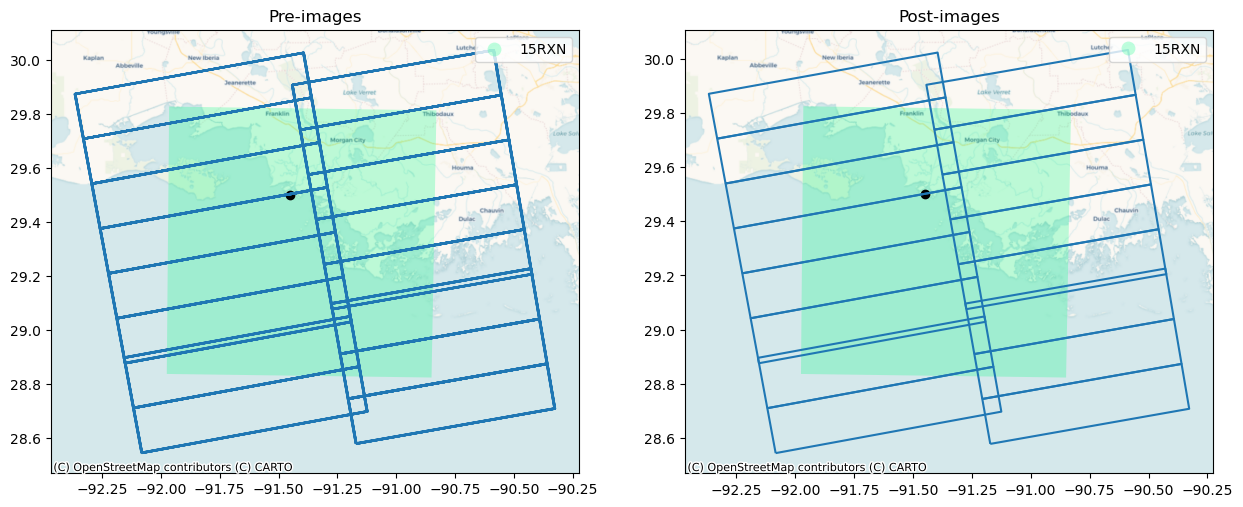

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for ax in axs:
    df_mgrs_tiles_plot.plot(
        column="mgrs_tile_id",
        categorical=True,
        legend=True,
        ax=ax,
        alpha=0.25,
        cmap="winter_r",
    )
    df_aoi.plot(ax=ax, color="black")


# pre-images
df_pre_prod.boundary.plot(ax=axs[0])
ctx.add_basemap(
    axs[0],
    crs=df_mgrs_tiles.crs.to_string(),
    source=ctx.providers.CartoDB.Voyager,
)
axs[0].set_title("Pre-images")


# Post-image
df_post_prod.boundary.plot(ax=axs[1])
ctx.add_basemap(
    axs[1],
    crs=df_mgrs_tiles.crs.to_string(),
    source=ctx.providers.CartoDB.Voyager,
)
axs[1].set_title("Post-images")